# Taller

• Implementar un modelo CNN o ViT. Puede ser un modelo de alguna librería (Keras) o una implementación “vanilla”
de una CNN

• Inventar una tarea de pretexto

• Entrenar en ImageNet


1. Cargar dataset e inspeccionar imagenes
2. Crear dataset con tarea de pretexto
3. Self-Supervised Learning con ViT y Jigsaw Puzzle

In [12]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import time
import kagglehub
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [ ]:
# librerias internas
from vit import ViT
from pretext_tasks import JigsawPuzzleDataset
from train import train_model, plot_training_history

## 1. Cargar dataset

In [ ]:

# Download latest version
path = kagglehub.dataset_download("ifigotin/imagenetmini-1000")

print("Path to dataset files:", path)

100%|██████████| 3.92G/3.92G [02:17<00:00, 30.6MB/s]

Extracting files...


Path to dataset files: /Users/andrestrepo/.cache/kagglehub/datasets/ifigotin/imagenetmini-1000/versions/1


🔍 Analizando imagen: ./imagenet-mini/train/n01440764/n01440764_3603.JPEG
📏 Dimensiones: 500 x 333 píxeles
🎨 Modo de color: RGB
📁 Formato: JPEG


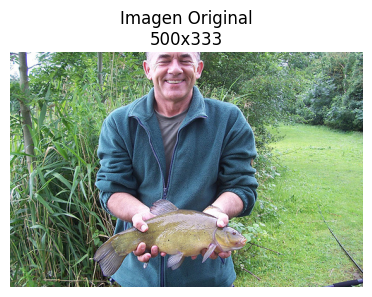

In [6]:
# Inspeccionar dimensiones de imágenes

def inspect_image_dimensions(image_path):
    """Inspeccionar dimensiones y propiedades de una imagen"""
    
    print(f"🔍 Analizando imagen: {image_path}")
    print("="*50)
    
    try:
        # Cargar imagen con PIL
        img = Image.open(image_path)
        
        # Obtener dimensiones
        width, height = img.size
        mode = img.mode
        format_type = img.format
        
        print(f"📏 Dimensiones: {width} x {height} píxeles")
        print(f"🎨 Modo de color: {mode}")
        print(f"📁 Formato: {format_type}")
        
        # Mostrar imagen
        plt.figure(figsize=(10, 5))
        
        # Imagen original
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title(f'Imagen Original\n{width}x{height}')
        plt.axis('off')
        
        
        
        return {
            'width': width,
            'height': height,
            'mode': mode,
            'format': format_type
        }
        
    except Exception as e:
        print(f"❌ Error al cargar la imagen: {e}")
        return None


image_path = "./imagenet-mini/train/n01440764/n01440764_3603.JPEG"


image_info = inspect_image_dimensions(image_path)

## 2. crear dataset Tarea de Pretexto: Jigsaw Puzzle

In [32]:
# Configuración de dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

# Configuración de hiperparámetros
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
NUM_EPOCHS = 10
PATCH_SIZE = 16
IMG_SIZE = 224
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2  # 196 patches para 224x224


Usando dispositivo: cpu


In [8]:
# Cargar y preparar datos
print("Cargando datos de ImageNet...")

# Transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Cargar ImageNet usando ImageFolder (formato de carpetas)
train_dataset = torchvision.datasets.ImageFolder(root='./imagenet-mini/train', transform=transform)
val_dataset = torchvision.datasets.ImageFolder(root='./imagenet-mini/val', transform=transform)
print("✓ ImageNet cargado exitosamente")

# Crear datasets de Jigsaw Puzzle
print("Creando datasets de Jigsaw Puzzle...")
train_jigsaw_dataset = JigsawPuzzleDataset(train_dataset, transform=None)
val_jigsaw_dataset = JigsawPuzzleDataset(val_dataset, transform=None)

Cargando datos de ImageNet...
✓ ImageNet cargado exitosamente
Creando datasets de Jigsaw Puzzle...


✓ Datasets creados:
  - Entrenamiento: 34745 muestras
  - Validación: 3923 muestras
  - Batch size: 32

Visualizando ejemplos de Jigsaw Puzzle...


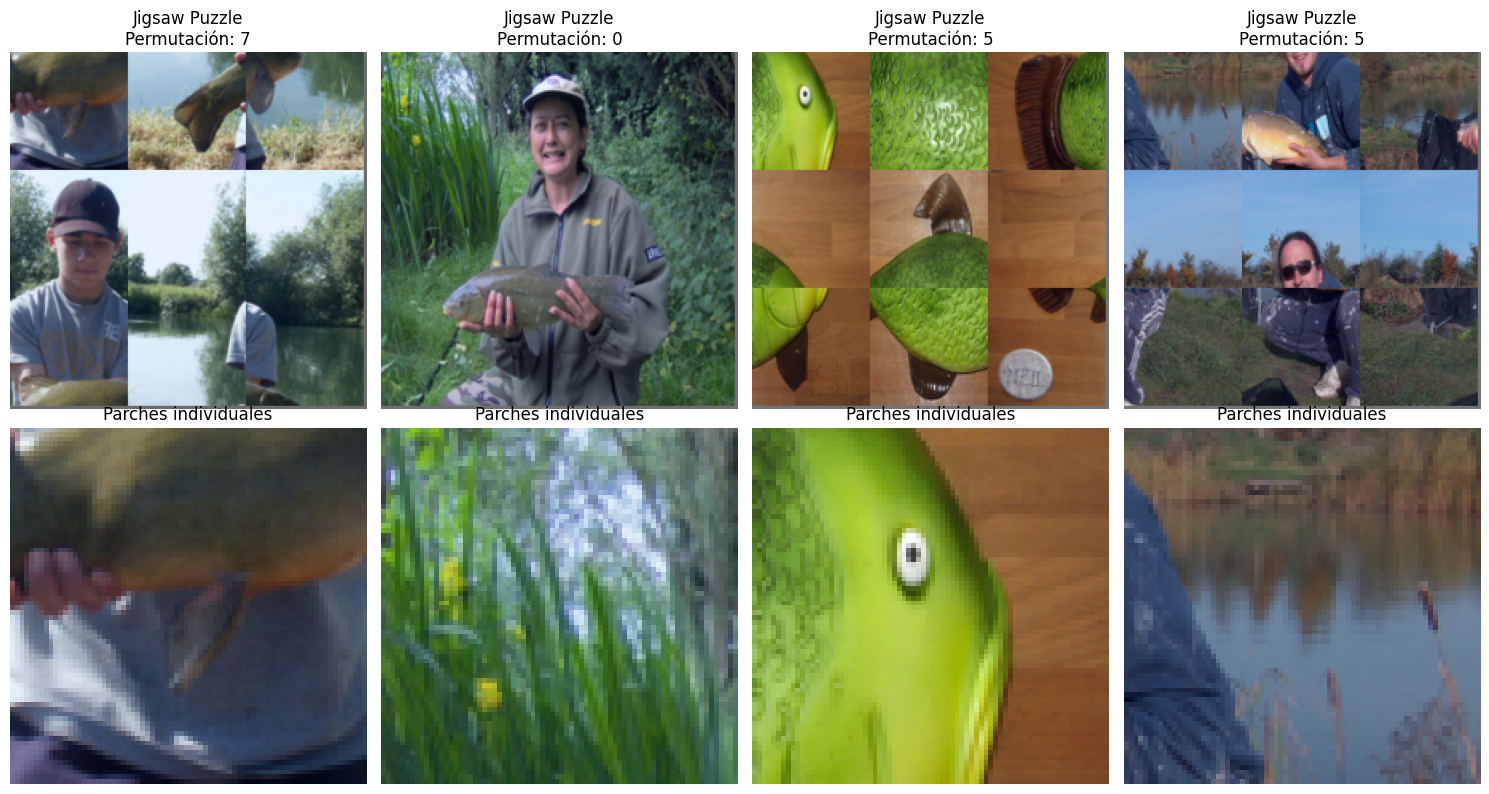

In [9]:
# Crear DataLoaders (sin multiprocessing para evitar errores en notebooks)
train_loader = DataLoader(train_jigsaw_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_jigsaw_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"✓ Datasets creados:")
print(f"  - Entrenamiento: {len(train_jigsaw_dataset)} muestras")
print(f"  - Validación: {len(val_jigsaw_dataset)} muestras")
print(f"  - Batch size: {BATCH_SIZE}")

# Visualizar algunos ejemplos de rompecabezas
print("\nVisualizando ejemplos de Jigsaw Puzzle...")
JigsawPuzzleDataset.visualize_jigsaw_puzzle(train_jigsaw_dataset, num_samples=4)


## 3.Instanciar, entrenar y evaluar modelo en tarea de pretexto

Inicializando modelo ViT-Base...
✓ Modelo ViT-Base creado
  - Parámetros totales: 85,805,577
  - Parámetros entrenables: 85,805,577

INICIANDO ENTRENAMIENTO
Iniciando entrenamiento...
Modelo: 85,805,577 parámetros
Early stopping: patience=3, min_delta=0.001
Epoch 1/10, Batch 0/1086, Loss: 2.3549
Epoch 1/10, Batch 100/1086, Loss: 2.3136
Epoch 1/10, Batch 200/1086, Loss: 2.2256
Epoch 1/10, Batch 300/1086, Loss: 2.2547
Epoch 1/10, Batch 400/1086, Loss: 2.1993
Epoch 1/10, Batch 500/1086, Loss: 1.9179
Epoch 1/10, Batch 600/1086, Loss: 1.8818
Epoch 1/10, Batch 700/1086, Loss: 1.2646
Epoch 1/10, Batch 800/1086, Loss: 1.5603
Epoch 1/10, Batch 900/1086, Loss: 1.4179
Epoch 1/10, Batch 1000/1086, Loss: 1.6484
  ✅ Nueva mejor pérdida de validación: 1.3404
  💾 Modelo guardado como mejor modelo
Epoch 1/10:
  Train Loss: 1.8639, Train Acc: 23.86%
  Val Loss: 1.3404, Val Acc: 39.49%
  Learning Rate: 0.000098
--------------------------------------------------
Epoch 2/10, Batch 0/1086, Loss: 1.2175
Epoc

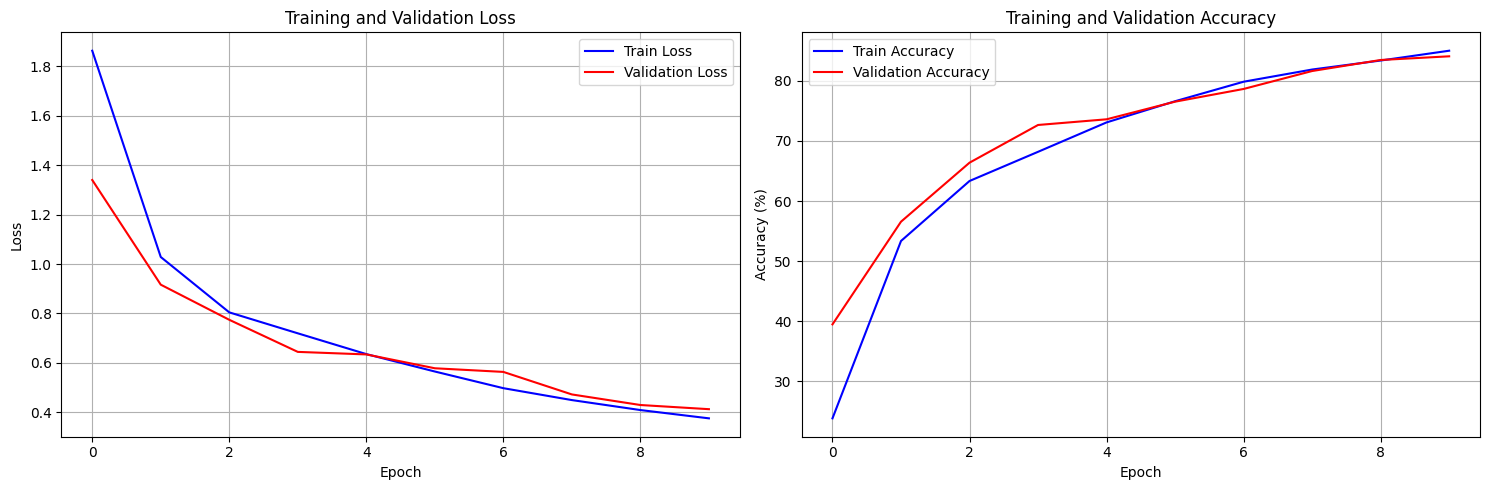


📊 MÉTRICAS FINALES:
  - Precisión de Entrenamiento: 85.00%
  - Precisión de Validación: 84.07%
  - Pérdida de Entrenamiento: 0.3751
  - Pérdida de Validación: 0.4122


In [13]:
# Crear e inicializar el modelo ViT
print("Inicializando modelo ViT-Base...")

model = ViT(
    img_size=IMG_SIZE,
    patch_size=PATCH_SIZE,
    in_channels=3,
    embed_dim=768,
    num_layers=12,
    num_heads=12,
    mlp_ratio=4,
    num_classes=9,  # 9 permutaciones diferentes
    dropout=0.1
)

print(f"✓ Modelo ViT-Base creado")
print(f"  - Parámetros totales: {sum(p.numel() for p in model.parameters()):,}")
print(f"  - Parámetros entrenables: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Ejecutar entrenamiento
print("\n" + "="*60)
print("INICIANDO ENTRENAMIENTO")
print("="*60)

start_time = time.time()
train_losses, val_losses, train_accs, val_accs = train_model(
    model, train_loader, val_loader, NUM_EPOCHS, LEARNING_RATE, device, patience=3,min_delta=0.001,
)
end_time = time.time()

print(f"\n✓ Entrenamiento completado en {end_time - start_time:.2f} segundos")

# Visualizar resultados
print("\nVisualizando resultados del entrenamiento...")
plot_training_history(train_losses, val_losses, train_accs, val_accs)

# Mostrar métricas finales
final_train_acc = train_accs[-1]
final_val_acc = val_accs[-1]
final_train_loss = train_losses[-1]
final_val_loss = val_losses[-1]

print(f"\n📊 MÉTRICAS FINALES:")
print(f"  - Precisión de Entrenamiento: {final_train_acc:.2f}%")
print(f"  - Precisión de Validación: {final_val_acc:.2f}%")
print(f"  - Pérdida de Entrenamiento: {final_train_loss:.4f}")
print(f"  - Pérdida de Validación: {final_val_loss:.4f}")

In [19]:
from eval import evaluate_model_comprehensive, plot_confusion_matrix, plot_classification_report, visualize_predictions, plot_probability_distribution
# Nombres de las clases (permutaciones del jigsaw puzzle)
class_names = [f'Permutación {i}' for i in range(9)]


In [20]:
# Ejecutar evaluación completa del modelo
print("="*60)
print("EVALUACIÓN COMPLETA DEL MODELO ViT")
print("="*60)

# Cargar el modelo si existe, sino usar el modelo actual
try:
    model.load_state_dict(torch.load('vit_jigsaw_model.pth', map_location=device))
    print("✓ Modelo cargado desde archivo guardado")
except:
    print("⚠️ No se encontró modelo guardado, usando modelo actual")

# Realizar evaluación completa
evaluation_results = evaluate_model_comprehensive(model, val_loader, device, class_names)

print("\n" + "="*60)
print("VISUALIZACIONES Y ANÁLISIS DETALLADO")
print("="*60)


EVALUACIÓN COMPLETA DEL MODELO ViT
✓ Modelo cargado desde archivo guardado
🔍 Evaluando modelo en conjunto de test...
Procesando batch 0/123
Procesando batch 50/123
Procesando batch 100/123

📊 MÉTRICAS DE EVALUACIÓN:
  - Accuracy: 0.8330 (83.30%)
  - F1-Score (Macro): 0.8360
  - F1-Score (Weighted): 0.8331
  - Precision (Macro): 0.8371
  - Recall (Macro): 0.8358

VISUALIZACIONES Y ANÁLISIS DETALLADO


📊 Generando Matriz de Confusión...


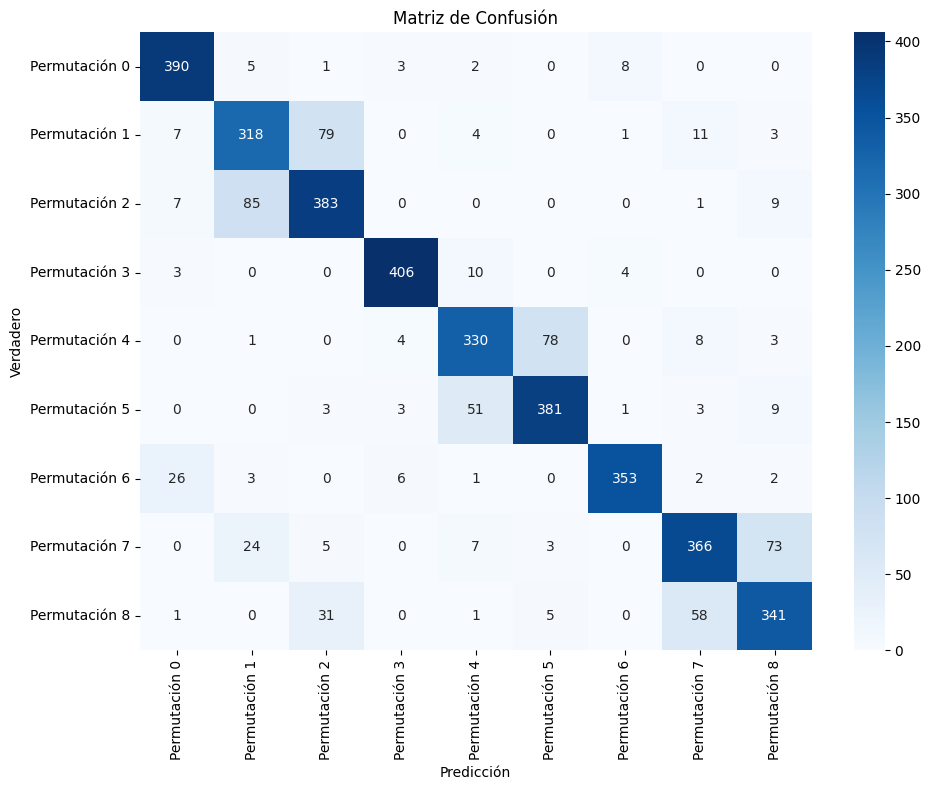


📈 Generando Reporte de Clasificación...


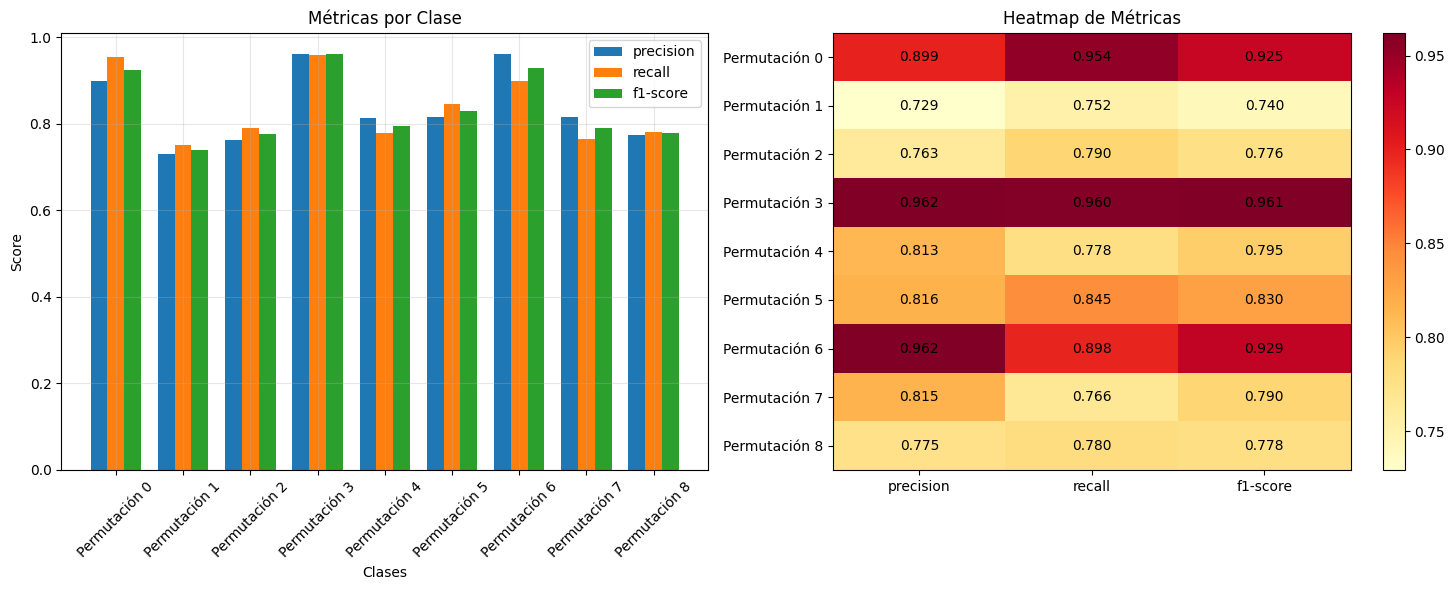


🖼️ Visualizando Predicciones del Modelo...


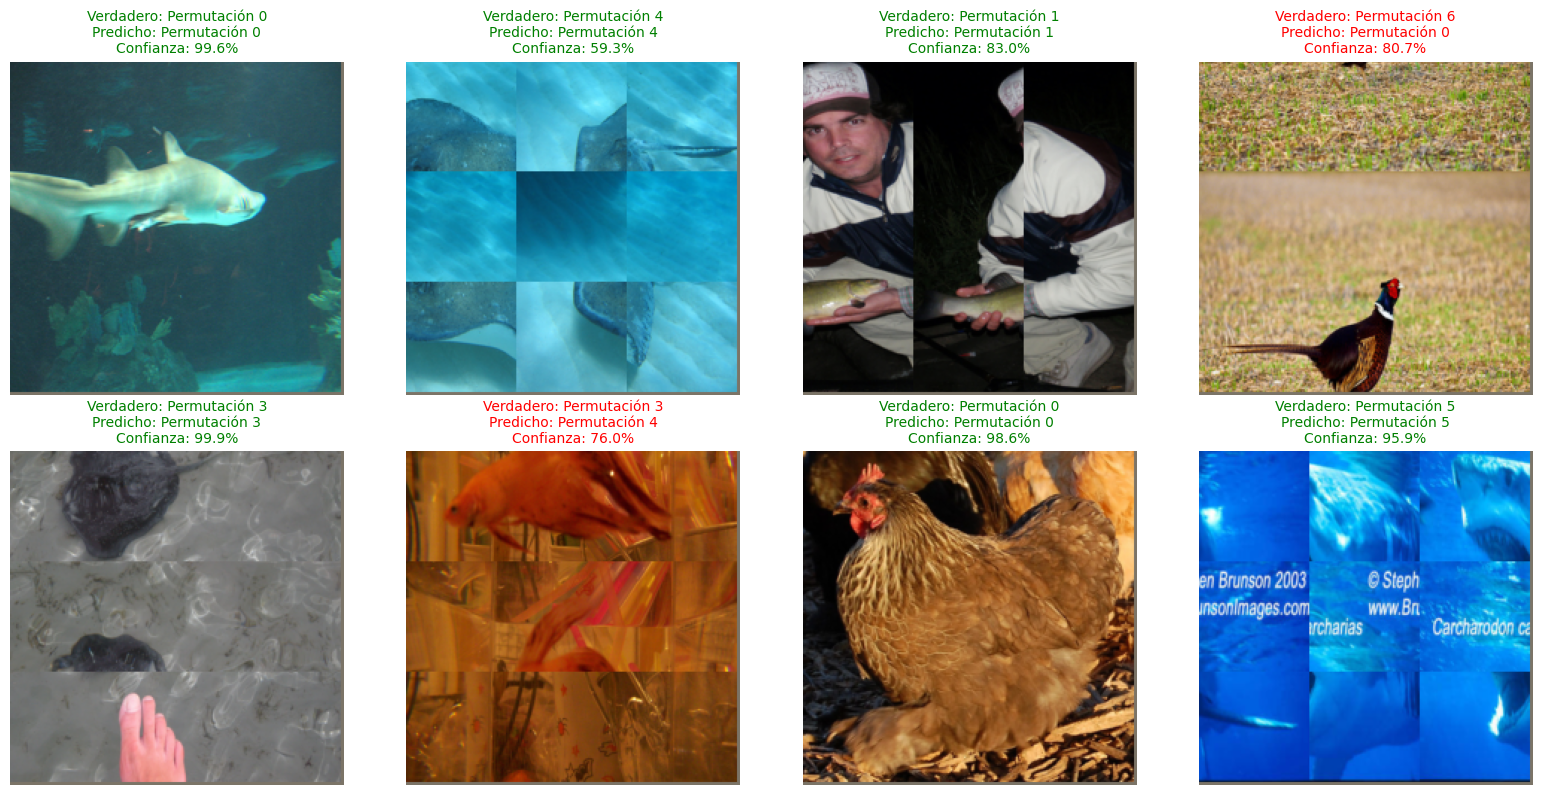


📊 Analizando Distribución de Probabilidades...


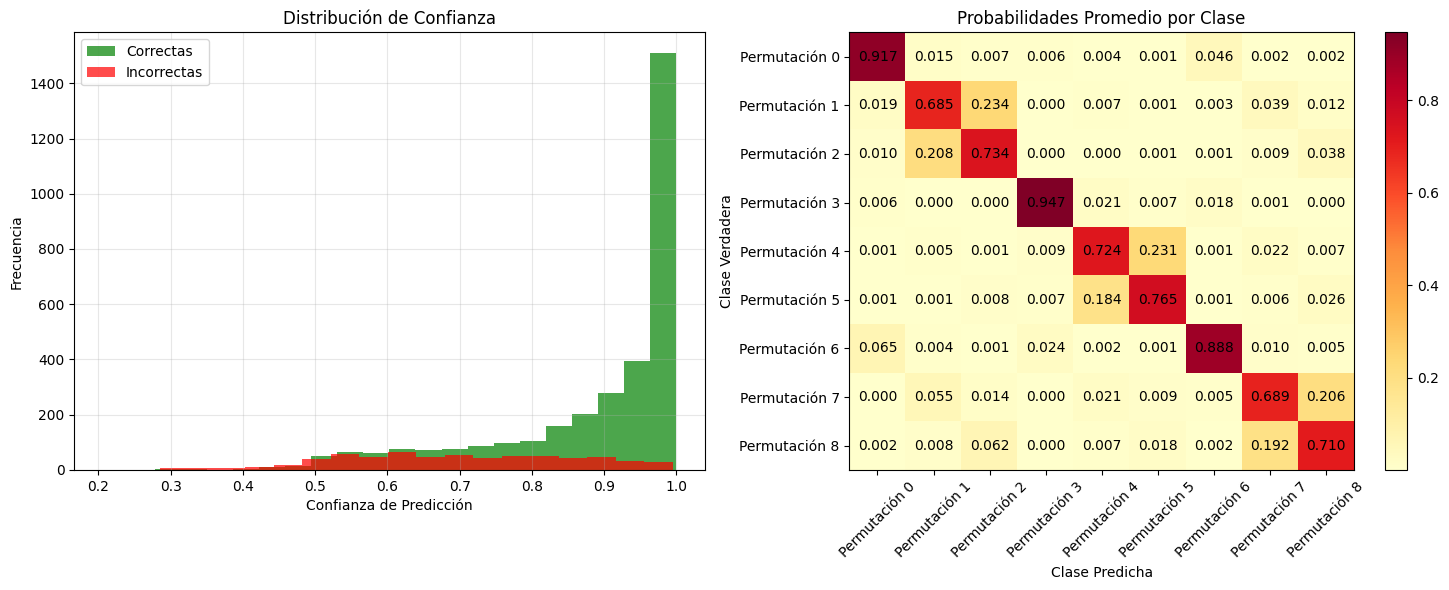

In [21]:
# 1. Matriz de Confusión
print("📊 Generando Matriz de Confusión...")
cm = plot_confusion_matrix(
    evaluation_results['targets'], 
    evaluation_results['predictions'], 
    class_names
)

# 2. Reporte de Clasificación Detallado
print("\n📈 Generando Reporte de Clasificación...")
classification_report_dict = plot_classification_report(
    evaluation_results['targets'], 
    evaluation_results['predictions'], 
    class_names
)

# 3. Visualización de Predicciones
print("\n🖼️ Visualizando Predicciones del Modelo...")
visualize_predictions(model, val_loader, device, num_samples=8, class_names=class_names)

# 4. Distribución de Probabilidades
print("\n📊 Analizando Distribución de Probabilidades...")
plot_probability_distribution(
    evaluation_results['probabilities'], 
    evaluation_results['targets'], 
    class_names
)


In [22]:
# Análisis adicional y métricas específicas
print("🔍 ANÁLISIS ADICIONAL DEL MODELO")
print("="*50)

# Análisis de errores más comunes
print("\n📋 Análisis de Errores:")
error_mask = evaluation_results['targets'] != evaluation_results['predictions']
error_count = np.sum(error_mask)
total_samples = len(evaluation_results['targets'])
error_rate = error_count / total_samples

print(f"  - Total de muestras: {total_samples}")
print(f"  - Errores: {error_count}")
print(f"  - Tasa de error: {error_rate:.4f} ({error_rate*100:.2f}%)")

# Análisis por clase
print(f"\n📊 Rendimiento por Clase:")
for i, class_name in enumerate(class_names):
    class_mask = evaluation_results['targets'] == i
    if np.sum(class_mask) > 0:
        class_correct = np.sum((evaluation_results['targets'] == i) & 
                              (evaluation_results['predictions'] == i))
        class_total = np.sum(class_mask)
        class_accuracy = class_correct / class_total
        print(f"  - {class_name}: {class_accuracy:.4f} ({class_accuracy*100:.2f}%) - {class_correct}/{class_total}")

# Análisis de confianza
print(f"\n🎯 Análisis de Confianza:")
correct_predictions = evaluation_results['targets'] == evaluation_results['predictions']
correct_confidences = np.max(evaluation_results['probabilities'][correct_predictions], axis=1)
incorrect_confidences = np.max(evaluation_results['probabilities'][~correct_predictions], axis=1)

print(f"  - Confianza promedio (correctas): {np.mean(correct_confidences):.4f}")
print(f"  - Confianza promedio (incorrectas): {np.mean(incorrect_confidences):.4f}")
print(f"  - Diferencia de confianza: {np.mean(correct_confidences) - np.mean(incorrect_confidences):.4f}")

# Top-K accuracy
def top_k_accuracy(y_true, y_prob, k=3):
    """Calcular top-k accuracy"""
    top_k_preds = np.argsort(y_prob, axis=1)[:, -k:]
    return np.mean([y_true[i] in top_k_preds[i] for i in range(len(y_true))])

top3_acc = top_k_accuracy(evaluation_results['targets'], evaluation_results['probabilities'], k=3)
top5_acc = top_k_accuracy(evaluation_results['targets'], evaluation_results['probabilities'], k=5)

print(f"\n🏆 Top-K Accuracy:")
print(f"  - Top-3 Accuracy: {top3_acc:.4f} ({top3_acc*100:.2f}%)")
print(f"  - Top-5 Accuracy: {top5_acc:.4f} ({top5_acc*100:.2f}%)")

# Resumen final
print(f"\n" + "="*60)
print("📋 RESUMEN FINAL DE EVALUACIÓN")
print("="*60)
print(f"✅ Accuracy General: {evaluation_results['accuracy']:.4f} ({evaluation_results['accuracy']*100:.2f}%)")
print(f"✅ F1-Score (Macro): {evaluation_results['f1_macro']:.4f}")
print(f"✅ F1-Score (Weighted): {evaluation_results['f1_weighted']:.4f}")
print(f"✅ Precision (Macro): {evaluation_results['precision_macro']:.4f}")
print(f"✅ Recall (Macro): {evaluation_results['recall_macro']:.4f}")
print(f"✅ Top-3 Accuracy: {top3_acc:.4f} ({top3_acc*100:.2f}%)")
print(f"✅ Top-5 Accuracy: {top5_acc:.4f} ({top5_acc*100:.2f}%)")
print(f"✅ Tasa de Error: {error_rate:.4f} ({error_rate*100:.2f}%)")

print(f"\n🎯 El modelo ViT ha sido evaluado exitosamente en la tarea de Jigsaw Puzzle!")
print(f"📊 Se han generado visualizaciones completas de las predicciones y métricas.")


🔍 ANÁLISIS ADICIONAL DEL MODELO

📋 Análisis de Errores:
  - Total de muestras: 3923
  - Errores: 655
  - Tasa de error: 0.1670 (16.70%)

📊 Rendimiento por Clase:
  - Permutación 0: 0.9535 (95.35%) - 390/409
  - Permutación 1: 0.7518 (75.18%) - 318/423
  - Permutación 2: 0.7897 (78.97%) - 383/485
  - Permutación 3: 0.9598 (95.98%) - 406/423
  - Permutación 4: 0.7783 (77.83%) - 330/424
  - Permutación 5: 0.8448 (84.48%) - 381/451
  - Permutación 6: 0.8982 (89.82%) - 353/393
  - Permutación 7: 0.7657 (76.57%) - 366/478
  - Permutación 8: 0.7803 (78.03%) - 341/437

🎯 Análisis de Confianza:
  - Confianza promedio (correctas): 0.8911
  - Confianza promedio (incorrectas): 0.6962
  - Diferencia de confianza: 0.1950

🏆 Top-K Accuracy:
  - Top-3 Accuracy: 0.9893 (98.93%)
  - Top-5 Accuracy: 0.9980 (99.80%)

📋 RESUMEN FINAL DE EVALUACIÓN
✅ Accuracy General: 0.8330 (83.30%)
✅ F1-Score (Macro): 0.8360
✅ F1-Score (Weighted): 0.8331
✅ Precision (Macro): 0.8371
✅ Recall (Macro): 0.8358
✅ Top-3 Accurac